In [1]:
# # import os
# import json
# import pathlib
# import typing as tp
# # from os.path import abspath, dirname, join

# import cv2
# import torch
# import pandas as pd
# import numpy as np
# from PIL import Image
# from matplotlib import pyplot as plt
# from torch.utils.data import DataLoader
# from torch.utils.tensorboard import SummaryWriter

# # from dataset import (
# #     ImagePointsDataset,
# #     convert_targets_shape,
# #     show_face
# # )
# # from model import NeuralNetwork
# from detection import train_detector, detect


def read_csv(filename):
    res = {}
    with open(filename) as fhandle:
        next(fhandle)
        for line in fhandle:
            parts = line.rstrip('\n').split(',')
            coords = np.array([float(x) for x in parts[1:]], dtype='float64')
            res[parts[0]] = coords
    return res


# data_dir = pathlib.Path("/home/david/study/shad/cv_fall_2022/lesson_6_nn_intro/public_tests/00_test_img_input")
# output_dir = ""

# train_dir = data_dir/'train'
# test_dir = data_dir/'test'

# train_gt: tp.Dict[str, np.ndarray] = read_csv(train_dir/'gt.csv')
# train_img_dir = train_dir/'images'

# NET_ARCHITECTURE = []

# model = train_detector(train_gt, train_img_dir, fast_train=False)

# # code_dir = dirname(abspath(__file__))
# # model_filename = join(code_dir, 'facepoints_model.ckpt')
# model_filename = './facepoints_model.ckpt'
# test_img_dir = test_dir/'images'
# detected_points = detect(model_filename, test_img_dir)
# # save_csv(detected_points, join(output_dir, 'output.csv'))

In [5]:
import sys; sys.path.append('../')

import json
import pathlib
import typing as tp

import cv2
import torch
import torchvision
import pandas as pd
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from dataset import (
    ImagePointsDataset,
    convert_targets_shape,
    show_face
)
from net_factory import NeuralNetwork
from transforms import (
    FacePointsRandomCropTransform,
    FacePointsRandomHorizontalFlipTransform
)


data_dir = pathlib.Path("/home/david/study/shad/cv_fall_2022/lesson_6_nn_intro/data/00_test_img_input")
output_dir = ""

train_dir = data_dir/'train'
test_dir = data_dir/'test'

train_gt: tp.Dict[str, np.ndarray] = read_csv(train_dir/'gt.csv')
train_img_dir = train_dir/'images'

test_img_dir = test_dir/'images'

In [6]:
# transforms = [
#     FacePointsRandomHorizontalFlipTransform(0.5),
#     FacePointsRandomCropTransform((0.8, 0.8), skip=True)
# ]

In [17]:
ds = ImagePointsDataset("train", 0.932, train_img_dir, train_gt)  #, transforms=transforms)
len(ds)

5592

In [19]:
transforms = torch.nn.Sequential(
    torchvision.transforms.CenterCrop(10),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
)

In [20]:
type(transforms)

torch.nn.modules.container.Sequential

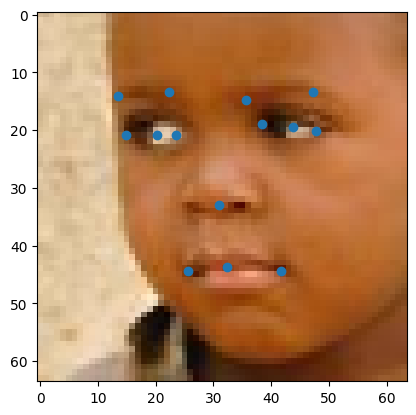

In [10]:
show_face(ds, 121)

In [13]:
isinstance([1,2], tp.iterable)

AttributeError: module 'typing' has no attribute 'iterable'

In [14]:
with open('./configs/architectures/simple_cnn.json') as f:
    net_arch = json.load(f)

In [15]:
with open('./configs/learning_process/base.json') as f:
    learning_process = json.load(f)

In [10]:
dataset_params = learning_process["dataset_params"]
train_fraction = dataset_params["train_fraction"]
transforms = [
    globals()[dict_["transform_type"]](**dict_["params"]) 
        for dict_ in dataset_params["augmentation"]
]

train_dataset = ImagePointsDataset(
    mode="train",
    train_fraction=train_fraction,
    data_dir=train_img_dir,
    train_gt=train_gt,
    new_size=dataset_params["new_size"],
    transforms=transforms
)

val_dataset = ImagePointsDataset(
    mode="val",
    train_fraction=train_fraction,
    data_dir=train_img_dir,
    train_gt=train_gt,
    new_size=dataset_params["new_size"]
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size = dataset_params["train_batch_size"],
    shuffle=True
)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size = dataset_params["val_batch_size"],
    shuffle=True
)

In [11]:
loss_params = learning_process["hyper_params"]["loss"]
optimizer_params = learning_process["hyper_params"]["optimizer"]
epoch_nums = learning_process["hyper_params"]["epoch_nums"]

net = NeuralNetwork(net_arch)
loss = getattr(torch.nn, loss_params["loss_type"])(**loss_params["params"])
optimizer = getattr(torch.optim, optimizer_params["optimizer_type"])(
    net.parameters(),
    **optimizer_params["params"]
)
optimizer.zero_grad()

best_val_loss = float("inf")

In [12]:
!rm -rf ./runs

# default `log_dir` is "runs".
writer = SummaryWriter('./runs')

for epoch in range(epoch_nums):
    print(f"{epoch=}:")

    net.train()
    loss_history = []
    for X, y, _ in train_dataloader:
        optimizer.zero_grad()
        y_pred = net(X)
        loss_value = loss(y_pred, y)
        loss_value.backward()
        optimizer.step()
        cur_train_loss = loss_value.cpu().data.item()
        loss_history.append(cur_train_loss)
        print("train_loss: %.4f" % cur_train_loss, end='\r')

    train_loss = np.mean(loss_history)
    print("train_loss:\t%.5f" % train_loss)

    net.eval()
    loss_history = []
    with torch.no_grad():
        for X, y, shape in val_dataloader:
            shape = shape.numpy()
            y_pred = net(X)
            loss_value = loss(y_pred, y) 
            loss_history.append(loss_value.cpu().data.item())

    val_loss = np.mean(loss_history)
    print("val_loss:\t%.5f" % val_loss)
    print("val_quality:\t%.5f" % (val_loss * 100**2))
    
    writer.add_scalars(
        'Loss', 
        {
            'train': train_loss,
            'val': val_loss
        },
        epoch
    )
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(
            {
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            },
            pathlib.Path("./facepoints_model.ckpt")
        )
        print("*")
    print()

writer.close()

epoch=0:
train_loss:	0.03444
val_loss:	0.01795
val_quality:	179.49445
*

epoch=1:
train_loss:	0.01781
val_loss:	0.01120
val_quality:	112.01617
*

epoch=2:
train_loss:	0.01133
val_loss:	0.00697
val_quality:	69.68227
*

epoch=3:
train_loss:	0.00778
val_loss:	0.00493
val_quality:	49.25561
*

epoch=4:
train_loss:	0.00586
val_loss:	0.00353
val_quality:	35.27148
*

epoch=5:
train_loss:	0.00488
val_loss:	0.00331
val_quality:	33.08512
*

epoch=6:
train_loss:	0.00454
val_loss:	0.00288
val_quality:	28.77223
*

epoch=7:
train_loss:	0.00439
val_loss:	0.00300
val_quality:	30.03531

epoch=8:
train_loss:	0.00440
val_loss:	0.00293
val_quality:	29.27362

epoch=9:
train_loss:	0.00427
val_loss:	0.00300
val_quality:	29.95977

epoch=10:
train_loss:	0.00435
val_loss:	0.00288
val_quality:	28.81908

epoch=11:
train_loss:	0.00420
val_loss:	0.00269
val_quality:	26.87599
*

epoch=12:
train_loss:	0.00401
val_loss:	0.00255
val_quality:	25.50237
*

epoch=13:
train_loss:	0.00374
val_loss:	0.00243
val_quality:	24.274

FileNotFoundError: [Errno 2] No such file or directory: '/home/david/study/shad/cv_fall_2022/lesson_6_nn_intro/public_tests/00_test_img_input/train/images/01169.jpg'

In [64]:
net = NeuralNetwork(net_arch)
optimizer = getattr(torch.optim, optimizer_params["optimizer_type"])(
    net.parameters(),
    **optimizer_params["params"]
)

checkpoint = torch.load("./facepoints_model.ckpt")
net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [65]:
test_gt = {path.name: np.array([]) for path in test_img_dir.iterdir()}

In [66]:
dataset_params = learning_process["dataset_params"]

test_dataset = ImagePointsDataset(
    mode="test",
    train_fraction=0.0,
    data_dir=test_img_dir,
    train_gt=test_gt,
    new_size=dataset_params["new_size"]
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size = dataset_params["val_batch_size"],
    shuffle=False
)

In [67]:
y_pred_history = []
for i, (X, y, _) in enumerate(test_dataloader):
    print(f"iter={i}/{len(test_dataloader) - 1}", end='\r')
    y_pred = net(X)
    y_pred_reshaped = convert_targets_shape(
        y_pred.cpu().data.numpy(),
        test_dataset.shape
    )
    y_pred_history.extend(y_pred_reshaped.tolist())
    break

In [68]:
paths = ["1", "2", "3"]
vals = [[1,2,3], [11,22,33], [0,0,0]]

for a, b in zip(paths, vals):
    print(a, b)

1 [1, 2, 3]
2 [11, 22, 33]
3 [0, 0, 0]


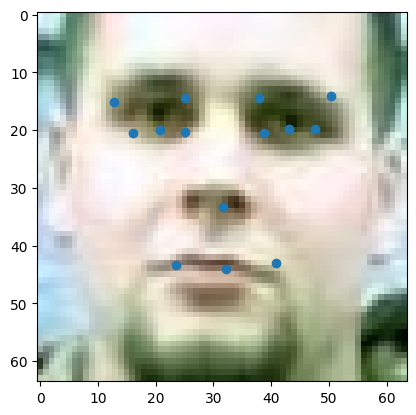

In [48]:
i += 1

plt.imshow(test_dataset[i][0].numpy().transpose(1, 2, 0));
plt.scatter(y_pred_history[i][::2], y_pred_history[i][1::2])

In [65]:
d = []
d.extend(y_pred.cpu().data.tolist())
d.extend(y_pred.cpu().data.tolist())

In [408]:
net(val_dataset[0][0].unsqueeze(0)),\
val_dataset[0][1]

(tensor([[0.2690, 0.2840, 0.4220, 0.2754, 0.5755, 0.2979, 0.7259, 0.3105, 0.3061,
          0.3598, 0.3619, 0.3624, 0.4086, 0.3520, 0.5807, 0.3439, 0.6322, 0.3450,
          0.7278, 0.3623, 0.4857, 0.5165, 0.3973, 0.6255, 0.4922, 0.6351, 0.6273,
          0.6611]], grad_fn=<SigmoidBackward0>),
 tensor([0.2222, 0.2407, 0.4074, 0.2407, 0.5926, 0.2222, 0.7222, 0.2037, 0.2593,
         0.2963, 0.2963, 0.2963, 0.3519, 0.2963, 0.6667, 0.2963, 0.7222, 0.2963,
         0.7593, 0.2963, 0.5556, 0.5556, 0.3148, 0.6667, 0.5000, 0.6852, 0.6481,
         0.6481]))

In [606]:
def train_detector(
        train_gt: tp.Dict[str, np.ndarray],
        train_img_dir: pathlib.PosixPath,
        fast_train: bool
) -> NeuralNetwork:
    
    # Create train and val Dataloaders.
    train_fraction = 0.9

    train_dataset = ImagePointsDataset(
        mode="train",
        train_fraction=train_fraction,
        data_dir=train_img_dir,
        train_gt=train_gt,
        new_size=(64, 64)
    )

    val_dataset = ImagePointsDataset(
        mode="val",
        train_fraction=train_fraction,
        data_dir=train_img_dir,
        train_gt=train_gt,
        new_size=(64, 64)
    )

    train_dataloader = DataLoader(
        dataset=train_dataset,
        batch_size = 100,
        shuffle=True
    )

    val_dataloader = DataLoader(
        dataset=val_dataset,
        batch_size = 100,
        shuffle=True
    )

    # Init blank model and optimizer.
    net = NeuralNetwork()
    loss = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.5)
    optimizer.zero_grad()

    epoch_nums = 1 if fast_train else 30
    best_val_loss = float("inf")
    
    # Process of training and validation.
    for epoch in range(epoch_nums):
        if not fast_train:
            print(f"{epoch=}:")

        loss_history = []
        for i, (X, y, _) in enumerate(train_dataloader):
            if fast_train and i > 20:
                break
            optimizer.zero_grad()
            y_pred = net(X)
            loss_value = loss(y_pred, y)
            loss_value.backward()
            optimizer.step()
            loss_history.append(loss_value.cpu().data.item())
            if not fast_train:
                print("train_loss: %.4f" % loss_value.cpu().data.item(), end='\r')

        train_loss = np.mean(loss_history)
        if not fast_train:
            print("train_loss:\t%.5f" % train_loss)

        loss_history = []
        for X, y, shape in val_dataloader:
            shape = shape.numpy()
            y_pred = net(X)
            loss_value = loss(y_pred, y) 
            loss_history.append(loss_value.cpu().data.item())
            if fast_train:
                break
        val_loss = np.mean(loss_history)
        if not fast_train:
            print("val_loss:\t%.5f" % val_loss)
            print("val_quality:\t%.5f" % (val_loss * 100**2))

        if not fast_train and val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(
                {
                    'model_state_dict': net.state_dict()
                },
                pathlib.Path("./facepoints_model.ckpt")
            )
            print("*")

        if not fast_train:
            print()
            
    # Load best one model.
    if not fast_train:
        net = NeuralNetwork()
        checkpoint = torch.load("./facepoints_model.ckpt")
        net.load_state_dict(checkpoint['model_state_dict'])       
            
    return net

In [ ]:
# detected_points = detect(model_filename, test_img_dir)
def detect(
        model_filename: str,
        test_img_dir: pathlib.PosixPath
) -> np.ndarray:
    net = NeuralNetwork()
    checkpoint = torch.load(model_filename)
    net.load_state_dict(checkpoint['model_state_dict'])

    train_dataset = ImagePointsDataset(
        mode="val",
        train_fraction=0.0,
        data_dir=test_img_dir,
        train_gt=None,
        new_size=(64, 64)
    )
    
    train_dataloader = DataLoader(
        dataset=train_dataset,
        batch_size = 100,
        shuffle=True
    )    
    